# Creating machine learning models 

## High level ML project managment

The need and the steps taken when creating a machine learning model usually falls into the following steps: 

![ml-flow](media/ml-flow.png)

* The business first needs to define the problem and the potential value that a solution will bring. 
* The second step is to transfer the business problem into a machine learning problem. 
* The third step is to run alot of experiments: try out many ML algorithms, do feature engineering, debate with your colleagues and present the results. 
* The final step is to decide which model to use and start thinking about deployment. 

The deployment part historicaly is not the part of an ML practioner but this is changing rapidly. 

If any problem is to big to overcome in a given step, then a team should go a step back and rethink the previous step. 

## Business problem 

![CSGO-logo](media/csgo-logo.jpeg)

Imagine that we are working in a huge analytics company and our new task is to model the probability of Counter Terrorist (**CT** for short) team winning a Counter Strike: Global Offensive (**CSGO** for short) game.

The rules of the game are simple: there are two teams, named terrorists and counter-terrorists, each consisting of 5 players. At the start of the round each player buys weapons, armor and other equipment and the objective is to win the match.

To read more about the game visit the official website: https://blog.counter-strike.net/index.php/about/

This esport is very popular and our analytics company is trying to break into the gaming market with a very accurate model which will be shown on TV, on gaming streams and other places. 

## Rules of the game 

The ultimate victory of a CSGO match is when a team, either CT or T, earn **16 points**. A point is earn when a match is won. 

Match winning criteria: 

* A given team eliminates all 5 players of the oposite team. 
* If the terrorists have planted the bomb, then the winning criteria for a CT team is to defuse the bomb and for the T team to win the match the bomb needs to explode.

The maximum number of seconds in a match is **175.00**.

There are 5 CT and 5 T players on match start. Each of them have **100 hit points (HP)** and can buy up to **100 armor** and a helmet.

Players earn in game dollars during a match which can be spent on weapons, grenades, armor and other accesories. 

## Machine learning problem 

After the business problem is defined and the rules of the game are clear, we now need to convert the business problem into a machine learning problem. 

If we define: 

$$ \mathbb{Y}_{i} = \{0, 1\}, \forall i = 1, ..., n$$ 

$$ \mathbb{X}_{i} \in R^{p}, \forall i = 1, ..., n$$

Where

$i$ - observation i. 

$n$ - total number of observations.

$p$ - number of features.

Then we are trying to create a model for the probability to observe $\mathbb{Y}=1$ event given $\mathbb{X}$:

$$P(\mathbb{Y}=1|\mathbb{X}) \in (0, 1)$$

$\mathbb{Y} = 1$ means that the CT team have won and the $\mathbb{Y} = 0$ means that CT team have lost.

The function $f$ that links $\mathbb{X}$ to $\mathbb{Y}$ is the machine learning model which are trying to build:

$$ f: \mathbb{X} \rightarrow \mathbb{Y} $$

Because we are trying to predict an observation falling into one of two classes (CT winning or losing) the machine learning model $f$ can be called a *binary classifier*. 

# Python package imports 

The first thing that any developer or a ML practioner does is load up packages which are installed into his/hers machine. 

In [126]:
# Data reading 
import pandas as pd 

# Main modeling class
import xgboost as xgb 

# Data spliting 
from sklearn.model_selection import train_test_split

# Plotting library
import matplotlib.pyplot as plt
import seaborn as sns 

# Array math 
import numpy as np

# Modeling frameworks 
from sklearn.linear_model import LogisticRegression 
import xgboost as xgb 

# Accuracy metrics 
from sklearn.metrics import roc_auc_score, roc_curve

# Hp parameter search 
from sklearn.model_selection import ParameterGrid

# Model saving 
import pickle

# Operating system functionalities
import os 

# JSON saving and loading 
import json

# Reading data 

Finding, cleaning and labelling data is ussually a long and painfull process. This is not the main emphasis of this book so lets imagine that we have already spent months in creating the beautifull dataset which we will read.

The original dataset can be found here: https://www.kaggle.com/christianlillelund/csgo-round-winner-classification

In [127]:
# Using pandas to read a csv file 
d = pd.read_csv("data/data.csv")

# Printing the shape of data 
print(f"Number of observations: {d.shape[0]}")
print(f"Number of features: {d.shape[1]}")

Number of observations: 122410
Number of features: 97


In [128]:
# Getting the feature names 
d.columns.values

array(['time_left', 'ct_score', 't_score', 'map', 'bomb_planted',
       'ct_health', 't_health', 'ct_armor', 't_armor', 'ct_money',
       't_money', 'ct_helmets', 't_helmets', 'ct_defuse_kits',
       'ct_players_alive', 't_players_alive', 'ct_weapon_ak47',
       't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug', 'ct_weapon_awp',
       't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',
       'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite',
       't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas',
       'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar',
       't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock',
       'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s',
       't_weapon_m4a1s', 'ct_weapon_m4a4', 't_weapon_m4a4',
       'ct_weapon_mac10', 't_weapon_mac10', 'ct_weapon_mag7',
       't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd',
       'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9',
       'ct_weapon_negev', 't_

In [129]:
# Displaying a snippet of data
print(d.head())

   time_left  ct_score  t_score       map  bomb_planted  ct_health  t_health  \
0     175.00       0.0      0.0  de_dust2         False      500.0     500.0   
1     156.03       0.0      0.0  de_dust2         False      500.0     500.0   
2      96.03       0.0      0.0  de_dust2         False      391.0     400.0   
3      76.03       0.0      0.0  de_dust2         False      391.0     400.0   
4     174.97       1.0      0.0  de_dust2         False      500.0     500.0   

   ct_armor  t_armor  ct_money  ...  t_grenade_flashbang  \
0       0.0      0.0    4000.0  ...                  0.0   
1     400.0    300.0     600.0  ...                  0.0   
2     294.0    200.0     750.0  ...                  0.0   
3     294.0    200.0     750.0  ...                  0.0   
4     192.0      0.0   18350.0  ...                  0.0   

   ct_grenade_smokegrenade  t_grenade_smokegrenade  \
0                      0.0                     0.0   
1                      0.0                     2.0

A short description about the data from the kaggle source: 
    
*The dataset consists of round snapshots from about 700 demos from high level tournament play in 2019 and 2020. Warmup rounds and restarts have been filtered, and for the remaining live rounds a round snapshot has been recorded every 20 seconds until the round is decided. Following its initial publication, It has been pre-processed and flattened to improve readability and make it easier for algorithms to process. The total number of snapshots is 122411. **Snapshots are i.i.d and should be treated as individual data points**, not as part of a match.*

The feature that will be used for the creation of $\mathbb{Y}$ variable is **round_winner**. If CT have won, then the value of $\mathbb{Y}$ will be 1 and 0 othervise.

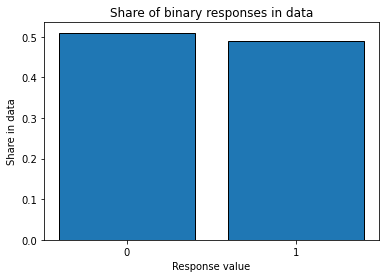

In [130]:
# Creating the Y variable 
d['Y'] = [1 if x == 'CT' else 0 for x in d['round_winner']]

# Inspecting the distribution of the classes
distribution = d.groupby('Y', as_index=False).size()
distribution['Y'] = distribution['Y'].astype(str)
distribution['share'] = distribution['size'] / distribution['size'].sum()
plt.bar(
    distribution['Y'], 
    distribution['share'],
    edgecolor='black'
)
plt.title("Share of binary responses in data")
plt.ylabel("Share in data")
plt.xlabel("Response value")
plt.show()

The classes are almost perfectly balanced.

## Dropping inconsistancies

In [131]:
d = d[(d['t_players_alive']<=5) & (d['ct_players_alive']<=5)].copy()

# Feature engineering 

Feature engineering is the process of using domain knowledge to create additional features from the raw features in data. Alot of experimentation time is spent here and not all the features created end up improving the model. Nevertheless, if we create atlest one new feature from the given list of features which improves the performance of our classifier then we have added imense value to the original dataset without investing into new data collection.

The AI expert Andrew Ng has proposed that the current ML industry should move from the model centric approach to the data centric approach {cite}`data_centric`:

*"If 80 percent of our work is data preparation, then ensuring data quality is the important work of a machine learning team."*

Andrew Ng urges to shift the focus from trying out new models while fixing a dataset and instead fix a model and then engineer new features, label new data points and do other data related experiments. 

Regardless of which school of thought wins out, developing new features is paramount in either case.


In [132]:
# Boolean for the planting of the bomb event 
d['bomb_planted'] = [1 if x else 0 for x in d['bomb_planted']]

# The differences between the team scores 
d['team_score_diff'] = d['ct_score'] - d['t_score']

# Putting the team_score_diff into buckets 
cut_bins_score = [-15, -5, 0, 5, 15]
d['team_score_diff'] = pd.cut(d['team_score_diff'], bins=cut_bins_score)

# Calculating the share of remaining health of CT
d['ct_health_share'] = d['ct_health'] / (d['t_health'] + d['ct_health'])

# Calculating the armor share 
d['ct_armor_per_player'] = d['ct_armor'] / d['ct_players_alive']

# Total money share owned by CT
d['ct_money_share'] = d['ct_money'] / (d['t_money'] + d['ct_money'])

# Difference between alive CT players and T players 
d['ct_players_alive_diff'] = d['ct_players_alive'] - d['t_players_alive']

# Is there a defuse kit in CT team?
d['ct_defuse_kit_present'] = [1 if x > 0 else 0 for x in d['ct_defuse_kits']]

# Explanatory Data Analysis 

## Bomb planting event 

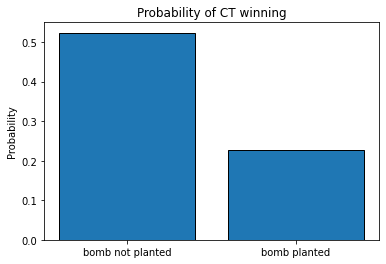

In [133]:
# Calculating the probability of winning when a bomb is planted
prob_w = d.groupby(['bomb_planted'])['Y'].agg(['sum', 'size'])
prob_w['prob_of_win_CT'] = prob_w['sum'] / prob_w['size']

# Adding a custom index 
prob_w.index = ['bomb not planted', 'bomb planted']

# Ploting the results 
plt.bar(
    prob_w.index, 
    prob_w['prob_of_win_CT'],
    edgecolor='black'
)
plt.title("Probability of CT winning")
plt.ylabel("Probability")
plt.show()

In [134]:
print(prob_w)

                    sum    size  prob_of_win_CT
bomb not planted  56904  108725        0.523375
bomb planted       3100   13684        0.226542


As we can see, if a bomb is planted, the odds of winning for a CT squad is more than two times lower than if the bomb is not planted: **0.52** and **0.22** respectively. 

## Maps 

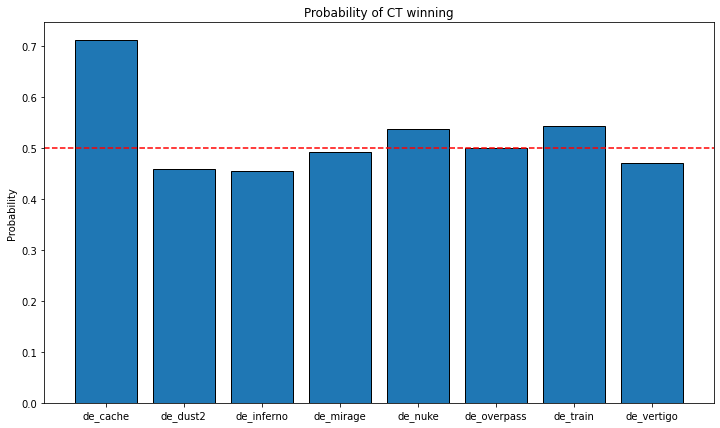

In [135]:
# Calculating the probability of winning when a bomb is planted
prob_w = d.groupby(['map'])['Y'].agg(['sum', 'size'])
prob_w['prob_of_win_CT'] = prob_w['sum'] / prob_w['size']

# Ploting the results 
plt.figure(figsize=(12, 7))
plt.bar(
    prob_w.index, 
    prob_w['prob_of_win_CT'],
    edgecolor='black'
)
plt.title("Probability of CT winning")
plt.ylabel("Probability")
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

In [136]:
print(prob_w)

               sum   size  prob_of_win_CT
map                                      
de_cache       103    145        0.710345
de_dust2     10158  22144        0.458725
de_inferno   10810  23811        0.453992
de_mirage     9144  18576        0.492248
de_nuke      10214  19025        0.536873
de_overpass   7026  14081        0.498970
de_train      7310  13491        0.541843
de_vertigo    5239  11136        0.470456


The map **de_cache** seems to be a clear outlier in the dataset: the CTs are winning in this map more than 70% of the maches. 

## Tilting 

The definition of tilting in esports is ***state of mental or emotional confusion or frustration***. We can measure that by the influence of the current score of matches in favor of CTs to the probablity of winning. 

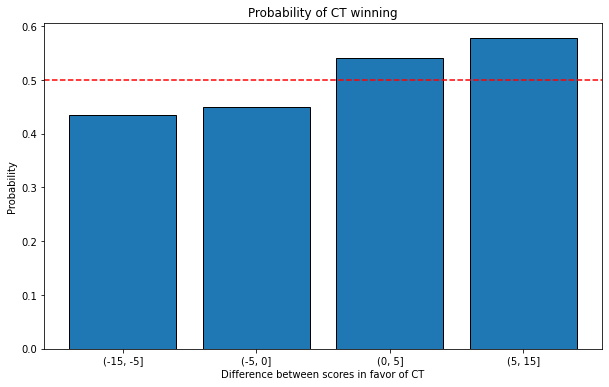

In [137]:
# Calculating the probability of winning when a bomb is planted
prob_w = d.groupby(['team_score_diff'])['Y'].agg(['sum', 'size'])
prob_w['prob_of_win_CT'] = prob_w['sum'] / prob_w['size']

# Adjusting the index
prob_w.index = [str(x) for x in prob_w.index] 

# Ploting the results 
plt.figure(figsize=(10, 6))
plt.bar(
    prob_w.index, 
    prob_w['prob_of_win_CT'],
    edgecolor='black'
)
plt.title("Probability of CT winning")
plt.ylabel("Probability")
plt.xlabel("Difference between scores in favor of CT")
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

There is a relationship between the matches won by CT and the probability of winning the current match: the bigger the difference between the match score in favor of CT, the higher the chances of winning. 

## Health, armor and money influence 

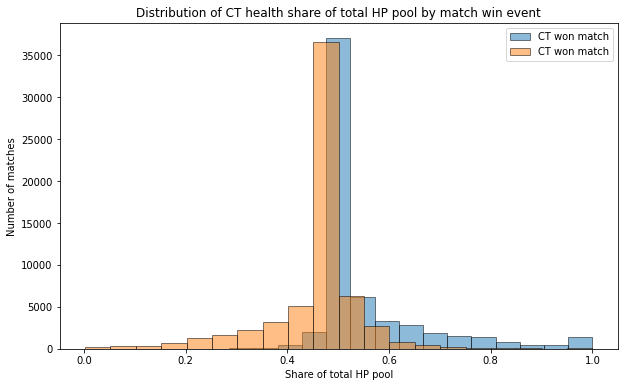

In [138]:
# Ploting the distributions of CT health share
plt.figure(figsize=(10, 6))
plt.hist(
    d.loc[d['Y']==1, 'ct_health_share'].values, 
    alpha=0.5, 
    label='CT won match', 
    edgecolor='black',
    bins=20
    )
plt.hist(
    d.loc[d['Y']==0, 'ct_health_share'].values, 
    alpha=0.5, 
    label='CT won match', 
    edgecolor='black',
    bins=20
    )
plt.legend()
plt.title("Distribution of CT health share of total HP pool by match win event")
plt.ylabel("Number of matches")
plt.xlabel("Share of total HP pool")
plt.show()

As our intuition suggested, the more total health is comprised of CT HP, the bigger the probability of winning. 

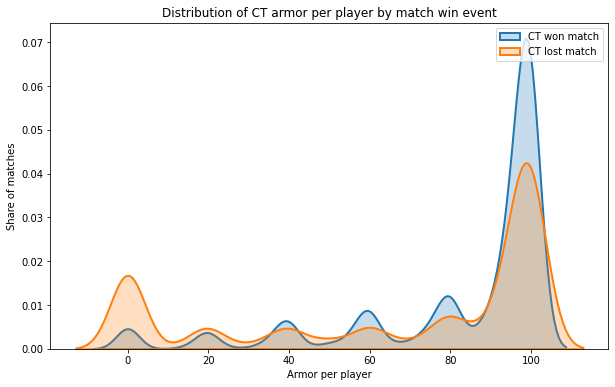

In [139]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    d.loc[d['Y']==1, 'ct_armor_per_player'].values,
    shade=True,
    linewidth=2,
    label = 'CT won match'
    )
sns.kdeplot(
    d.loc[d['Y']==0, 'ct_armor_per_player'].values,
    shade=True,
    linewidth=2,
    label = 'CT lost match'
    )
plt.legend()
plt.title("Distribution of CT armor per player by match win event")
plt.ylabel("Share of matches")
plt.xlabel("Armor per player")
plt.show()

The density of CT winning a match is "bigger" the more there is armor per player. 

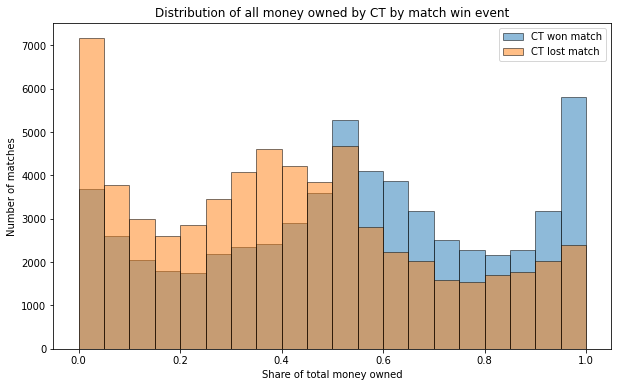

In [140]:
plt.figure(figsize=(10, 6))
plt.hist(
    d.loc[d['Y']==1, 'ct_money_share'].values, 
    alpha=0.5, 
    label='CT won match', 
    edgecolor='black',
    bins=20
    )
plt.hist(
    d.loc[d['Y']==0, 'ct_money_share'].values, 
    alpha=0.5, 
    label='CT lost match', 
    edgecolor='black',
    bins=20
    )
plt.legend()
plt.title("Distribution of all money owned by CT by match win event")
plt.ylabel("Number of matches")
plt.xlabel("Share of total money owned")
plt.show()

As with the health case, having more of the total economy in the game helps positively to win a match. 

## Impact of alive players

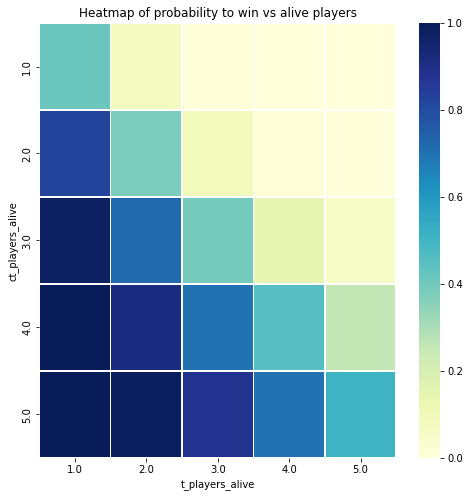

In [141]:
# Calculating the probability of winning when a bomb is planted
prob_w = d.groupby(['ct_players_alive', 't_players_alive'], as_index=False)['Y'].agg(['sum', 'size'])
prob_w['prob_of_win_CT'] = prob_w['sum'] / prob_w['size']

# Droping the obvious cases of CT=0 and T=0
prob_w = prob_w[[False if x[0]==0.0 or x[1]==0.0 else True for x in prob_w.index]]

# Creating a dataframe for a heatmap 
heatmap_df = pd.DataFrame({
    'ct_players_alive': prob_w.index.get_level_values(0),
    't_players_alive': prob_w.index.get_level_values(1),
    'p': prob_w['prob_of_win_CT']
})
heatmap_df = heatmap_df.pivot(index='ct_players_alive', columns='t_players_alive', values='p')

# Drawing the heatmap 
plt.figure(figsize=(8, 8))
sns.heatmap(heatmap_df, linewidths=.5, cmap="YlGnBu")
plt.title("Heatmap of probability to win vs alive players")
plt.show()

Even having one player advantage in a CSGO match leads to huge increases in probability of winning. The highest probability to win is where there are alot of alive CT players and not much alive T players.

## Defusal kit necesity 

If a bomb is planted in the game, the only way to defuse it is with a difusal kit. 

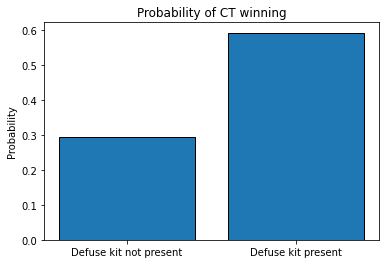

In [142]:
# Calculating the probability of winning when a bomb is planted
prob_w = d.groupby(['ct_defuse_kit_present'])['Y'].agg(['sum', 'size'])
prob_w['prob_of_win_CT'] = prob_w['sum'] / prob_w['size']

# Adding a custom index 
prob_w.index = ['Defuse kit not present', 'Defuse kit present']

# Ploting the results 
plt.bar(
    prob_w.index, 
    prob_w['prob_of_win_CT'],
    edgecolor='black'
)
plt.title("Probability of CT winning")
plt.ylabel("Probability")
plt.show()

In [143]:
prob_w 

,sum,size,prob_of_win_CT
Defuse kit not present,12418,42094,0.295006
Defuse kit present,47586,80315,0.592492


Having a defusal kit in a team really proves to be beneficial!

# Evaluating model performance 

In order to compare algorithms with one another or to measure the impact of new data and features, we need to have a performance metric (or more than one). One of the most popular metrics in measuring binary classifiers is the **Area Under the Curve metric (AUC)**. In order to have a grasp on AUC we first need to make sense of some intermediate definitions. 

## Confusion matrix 

In the field of machine learning and specifically the problem of statistical classification, a confusion matrix is a specific table layout that allows visualization of the performance of an algorithm. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class, or vice versa – both variants are found in various textbooks and articles. 

![confusion-matrix](media/confusion-matrix.jpg)

The abbreviations stand for: 

**TP** - True Positives 

**FN** - False Negatives 

**FP** - False Positives 

**TN** - True Negatives 

The **actual values** refer to the actual ending of the matches. In our case, if CT have won this is termed as a *positive* and if CT have lost then this is termed as a *negative*. The predicted values refer to the outcome predicted by the machine learning algorithm. Thus: 

* If a match is actually won by CT and our algorithm predicted the same, then that observation is a True Positive. 

* If a match is actually won by CT but our algorithm predicted that CT lost, then that observation is a False Negative. 

* If a match is actually lost by CT but our algorithm predicted that CT won, then that observation is a False Positive. 

* If a match is actually lost by CT and our algorithm predicted that CT have lost, then that observation is a True Negative. 

A perfect classifier would have only TPs and TNs in the confusion matrix and no FNs and FPs. Most of the time, this is not the case. 

## Model treshold 

Most of the popular ML models do not just output 1 or 0 (meaning that CT have won or lost) given a set of features $\mathbb{X}$. Rather, they output a **probability**. Recall, that a binary classifier is just a probability model that: 

$$ f(\mathbb{X}) = P(\mathbb{Y} = 1| \mathbb{X}) \in (0, 1)$$

So the output of the algorithm can be 0.0148, 0.5897, 0.998 and so on. By default, a label of 1 (CT winning a match) is given to an observation when $f(\mathbb{X}) \geqslant 0.5$. In other words, the treshold **t** = 0.5. In general terms: 

$$ y_{predicted} = \begin{cases} 1, & f(\mathbb{X}) \geqslant t \\
0, & f(\mathbb{X}) < t \end{cases} t \in (0, 1)$$

Altough it is generaly advised to have the default treshold of 0.5, but in some cases a user can vary the treshold to achieve better results.

## Receiver operating characteristic curve (ROC)

A receiver operating characteristic curve, or **ROC** curve, is a graphical plot that illustrates the performance of a binary classifier as the threshold is varied. It is a 2D plot where the X axis is the **False Positive Rate (FPR)** and the Y axis is the **True Positive Rate (TPR)**. FPR and TPR are defined as follows: 

$$FPR = \dfrac{FP}{N}$$ 

$$TPR = \dfrac{TP}{P}$$

Here **FP** - number of false positives generated by the classifier, **TP** - number of true positives generated by the classifier and **N** and **P** are the total number of "negative" and "positive" class observations in the data respectively.

An example ROC plot: 

![roc-curve](media/roc-example.png)

Notice that the axis values are in the interval **[0, 1]**. Altough it may not look like it, but the orange curve is made up out of alot of points who are connected to make a line (hence the term "curve"). Every point was gotten using a different treshold **t**. We always want a classifier whose ROC curve spikes as much as possible to the top left corner. The more the curve is closer to the right bottom corner, the worse the classifier. 

If the curve shoots up rapidly that means that by adjusting the treshold by a little bit, the true positive rate (or the amount of "positive" class observations identified correctly) is very high while the errors that our model makes are minimal (FRP is near zero). Further adjusting the treshold may increase the total positive class observations identified but it will come with a cost of increasing the FPR.  

To put everything in an interactive way, please watch the video by the great StatQuest team about ROC curves: https://www.youtube.com/watch?v=4jRBRDbJemM 

Another great resource on this topic: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

## AUC statistic 

The area under the curve (AUC) statistic is the integral of a given ROC curve between the points (0,0) and (1,1):  

![auc-plots](media/auc-example.png)

The perfect estimator has an are under the curve of 1.0, a bad estimator has the value of 0.5 and bellow. In practise, a classifier with the AUC statistic above 0.8 is consider to be good and AUC above 0.9 is considered to be very good.   

For the objective of creating an ML model for the winner of a CSGO match, we will use the AUC statistic as the main measure of the "goodness" of the model.  

# Creating the train, validation and test sets 

When creating machine learning models it is very advised to split the data into a **train**, **validation** and **test** sets. A good general rule of thumb is to have ~80% of the data to train the algotithm, ~10% of the data to use in various parameter tuning and ~10% of the data to only use in final performance metric calculation. 

All of these datasets are needed to make sure that our model does not **overfit**.

## Overfitting problem 

As stated beautifully in the book "Introduction to Statistical Learning"{cite}`stat_learning`:

**"When we overfit the training data, the test performance metrics will be very large because the supposed patterns that the method found in the training data simply don’t exist in the test data. Note that regardless of whether or not overfitting has occurred, we almost always expect the training errors to be smaller than the test errors because most statistical learning methods either directly or indirectly seek to minimize the training errors"**

In other words, if we only use training data when creating ML models, we are blinded a bit and do not know how will the model perform with unseen data.  

As per {cite}`train_val_test`:

**"The training set the largest corpus of your dataset that you reserve for training your model. After training, inference on these images will be taken with a grain of salt, since the model has already had a chance to look at and memorize the correct output."**

**"The validation set is a separate section of your dataset that you will use during training to get a sense of how well your model is doing on images that are not being used in training. During training, it is common to report validation metrics continually after each training epoch <\...\>. You use these metrics to get a sense of when your model has hit the best performance it can reach on your validation set. You may choose to cease training at this point <\...\> As you work on your model, you can continually iterate on your dataset, image augmentations, and model design to increase your model's performance on the validation set."**

**"After all of the training experiments have concluded, you probably have gotten a sense on how your model might do on the validation set. But it is important to remember that the validation set metrics may have influenced you during the creation of the model, and in this sense you might, as a designer, overfit the new model to the validation set. Because the validation set is heavily used in model creation, it is important to hold back a completely separate stronghold of data - the test set. You can run evaluation metrics on the test set at the very end of your project, to get a sense of how well your model will do in production."**

## Feature list 

After the feature engineering steps and EDA we can define the final feature list which we will use in our models: 

In [144]:
# Initial list 
features = [
    'bomb_planted',
    'ct_health_share',
    'ct_players_alive',
    't_players_alive',
    'ct_defuse_kit_present',
    'ct_helmets',
    't_helmets'
]

**NOTE:** some of the features will be left out because of iterative inspection of model results and EDA.

In [145]:
# Creating dummy vars for the map feature
map_df = pd.get_dummies(d['map'])

# Map feature names 
map_features = map_df.columns.values.tolist()

# Concatenating the map_df to original dataframe 
d = pd.concat([d, map_df], axis=1)

# Adding the map features to the original feature list 
#features += map_features

In [146]:
# Creating dummy vars for the team_score_diff features
score_df = pd.get_dummies(d['team_score_diff'])

# Score feature names 
score_df.columns = [f"team_score_diff_in_{str(x)}" for x in score_df.columns]
score_features = score_df.columns.values.tolist()

# Concatenating the map_df to original dataframe 
d = pd.concat([d, score_df], axis=1)

# Adding the map features to the original feature list 
#features += score_features

In [147]:
print(f"""Final feature list: \n \n {features} \n \n Number of features: {len(features)}""")

Final feature list: 
 
 ['bomb_planted', 'ct_health_share', 'ct_players_alive', 't_players_alive', 'ct_defuse_kit_present', 'ct_helmets', 't_helmets'] 
 
 Number of features: 7


## Spliting the original dataset

We will use 80% of the data to train the model, 10% for validating our model and search for hyper parameters and 10% of the data will be reserved for the test set. 

For reproducibility, we will set a random seed of **123**.

In [148]:
# Setting the seed 
seed = 123

# Subseting the dataframe to the features needed + the target variable 
dsubset = d[features + ['Y']].copy()

# Dropping missing values 
dsubset.dropna(inplace=True)

# Reseting the indexz 
dsubset.reset_index(inplace=True, drop=True)

# Spliting to train and test sets 
train, test = train_test_split(dsubset, test_size=0.2, random_state=seed)

# Further spliting the test to test and validation sets 
test, val = train_test_split(test, test_size=0.5, random_state=seed)

In [149]:
print(f"Total number of rows of the dataset: {d.shape[0]}")
print(f"Rows in the train set: {train.shape[0]}")
print(f"Rows in the validation set: {val.shape[0]}")
print(f"Rows in the test set: {test.shape[0]}")

Total number of rows of the dataset: 122409
Rows in the train set: 97926
Rows in the validation set: 12241
Rows in the test set: 12241


## Creating the X and Y matrices 

In [150]:
# Final matrices for training and validating models 
train_X, train_Y = train[features], train['Y']
val_X, val_Y = val[features], val['Y']
test_X, test_Y = test[features], test['Y']

# Printing the stats about the distribution of Ys 
print(f"Share of CT wins in training: {np.sum(train_Y) / len(train_Y)}")
print(f"Share of CT wins in validation: {np.sum(val_Y) / len(val_Y)}")
print(f"Share of CT wins in testing: {np.sum(test_Y) / len(test_Y)}")

Share of CT wins in training: 0.4892367706227151
Share of CT wins in validation: 0.494812515317376
Share of CT wins in testing: 0.4932603545461972


# ML model creation 

## Performance metric for a binary classifier

As was stated in the introduction of this book, when creating an ML model we need to have a performance metric to see how the model is performing and to measure how it improves over time. 

One of the most popular choice is the **area under the curve (AUC)** metric. The metric calculates the plot bellow the **receiver operating curve (ROC)**. 

The ROC curve plots the true positive (TP) and the false positive (FP) rates using different tresholds. 

## Logistic Regression model 

Logistic regression {cite}`100_page_ml` is used when we want to model the probability: 

$$P(\mathbb{Y}|\mathbb{X})$$

The above probability reads as "the probability of $\mathbb{Y}$ given $\mathbb{X}$". In other words, how do the features in $\mathbb{X}$ influence the event of $\mathbb{Y}$? 

The full equation for the probability which we will be trying to fit to the given data is: 

$$ P(\mathbb{Y}|\mathbb{X}) = \dfrac{1}{1 + e^{-\mathbb{X} \beta }}$$

Where 

$\mathbb{X}$ - a feature matrix of $n$ observations and $p$ features.  

$\beta$ - a vector of dimensions $p$ x 1.  

In other words, we get a coefficient for each feature in the $\mathbb{X}$ matrix. 

What is very helpful in logistic regression is that a negative coefficient for a given feature means that increasing the feature $x_{i}$ will lower the probability of a CT win. If a coefficient is positive, then increasing the $x_{i}$ value increases the probability of a CT win. 

This simple fact helps us in some quick sanity checks - the logic of the EDA analysis should hold in respect to coefficient values and signs.

### Fitting logistic regression 

#### Hyper parameter tuning

We will try and find a combination of best hyper parameters from a given grid of parameters using the validation set. 

The full list of logistic regression HPs can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression

In [151]:
# Defining a list of hyperparameters 
hp_dict = {
    'C': [0.1, 0.5, 1, 1.5, 2], 
    'max_iter': [1000], 
    'fit_intercept': [True],
    'solver': ['liblinear'],
    'penalty': ['l1', 'l2']
}

# Creating the hp grid 
hp_grid = ParameterGrid(hp_dict)

In [152]:
# Placeholders for the iteration
auc_val_best = 0 
best_hp = {}
results = pd.DataFrame({})

# Iterating through all the parameters and evaluating the results 
for i, hp in enumerate(hp_grid): 
    # Initiating the empty model/classifier 
    clf = LogisticRegression(**hp)

    # Fitting on data 
    clf.fit(train_X, train_Y)

    # Predicting on the validation set 
    yhat_val = [x[1] for x in clf.predict_proba(val_X)]

    # Calculating the AUC metric 
    auc_val = roc_auc_score(val_Y, yhat_val)

    # Adding to the results frame 
    hp_results = pd.DataFrame(hp, index=[i])
    hp_results['auc'] = auc_val
    results = results.append(hp_results)

    # Checking if this is the highest auc 
    if auc_val > auc_val_best:
        auc_val_best = auc_val 
        best_hp = hp 

# Sorting by the AUC score 
results.sort_values('auc', ascending=False, inplace=True)

In [153]:
# Printing out the results frame 
print(results)

     C  fit_intercept  max_iter penalty     solver       auc
9  2.0           True      1000      l2  liblinear  0.826646
2  0.5           True      1000      l1  liblinear  0.826630
7  1.5           True      1000      l2  liblinear  0.826626
4  1.0           True      1000      l1  liblinear  0.826619
6  1.5           True      1000      l1  liblinear  0.826616
5  1.0           True      1000      l2  liblinear  0.826608
0  0.1           True      1000      l1  liblinear  0.826608
8  2.0           True      1000      l1  liblinear  0.826606
3  0.5           True      1000      l2  liblinear  0.826595
1  0.1           True      1000      l2  liblinear  0.826324


In [154]:
# Printing out the best hyper parameter dictionary
print(f"Best hp: {best_hp}")                                               

Best hp: {'C': 2, 'fit_intercept': True, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}


#### Testing the results on the test set 

Now that we have the best parameters according to the validation set, we can checkout the performance on the test set. 

The test set should be used as the final performance evaluation before deciding whether the model is sufficient or not. 

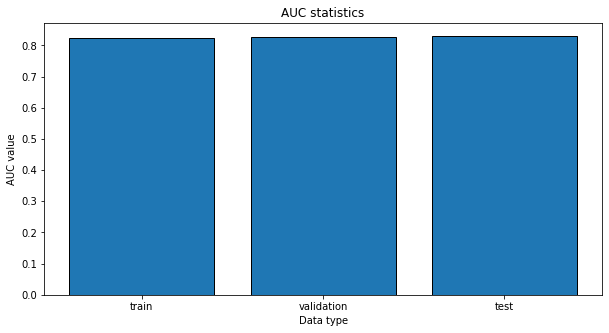

In [155]:
# Creating the final logistic regression classifier
clf_lr = LogisticRegression(**best_hp)
clf_lr.fit(train_X, train_Y)

# Getting the AUC statistics for train, validation and test sets 
yhat_train = [x[1] for x in clf_lr.predict_proba(train_X)]
yhat_val = [x[1] for x in clf_lr.predict_proba(val_X)]
yhat_test = [x[1] for x in clf_lr.predict_proba(test_X)]

train_auc = round(roc_auc_score(train_Y, yhat_train), 4)
val_auc = round(roc_auc_score(val_Y, yhat_val), 4)
test_auc = round(roc_auc_score(test_Y, yhat_test), 4)

# Creating a dataframe for ploting 
auc_lr_results = pd.DataFrame({
    'auc_lr': [train_auc, val_auc, test_auc]
}, index=['train', 'validation', 'test'])

# Ploting the results 
plt.figure(figsize=(10, 5))
plt.bar(
    auc_lr_results.index, 
    auc_lr_results['auc_lr'],
    edgecolor='black'
)
plt.title("AUC statistics")
plt.ylabel("AUC value")
plt.xlabel("Data type")
plt.show()

In [156]:
print(auc_lr_results)

            auc_lr
train       0.8250
validation  0.8266
test        0.8304


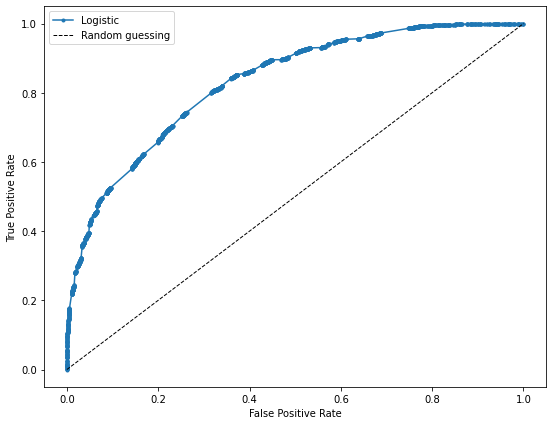

In [115]:
# Calculating the false positive rate and true positive rate for all the tresholds
fpr_logistic, tpr_logistic, _ = roc_curve(test_Y, yhat_test)

# Plot the roc curve for the model
plt.figure(figsize=(9, 7))
plt.plot(fpr_logistic, tpr_logistic, marker='.', label='Logistic')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 1, linestyle='--', label='Random guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

### Logistic regression coefficients 

In [116]:
# Creating the coefficient frame 
coef_frame = pd.DataFrame({
    'feature': clf_lr.feature_names_in_.tolist() + ['intercept'],
    'coefficient': clf_lr.coef_[0].tolist() + [clf_lr.intercept_[0]]
    })

# Sorting by coefficient value 
coef_frame.sort_values('coefficient', inplace=True)

# Printing the coef frame 
print(coef_frame)

                 feature  coefficient
7              intercept    -3.222694
0           bomb_planted    -1.286496
3        t_players_alive    -0.622889
6              t_helmets    -0.328168
5             ct_helmets     0.291658
4  ct_defuse_kit_present     0.599155
2       ct_players_alive     0.737419
1        ct_health_share     5.188518


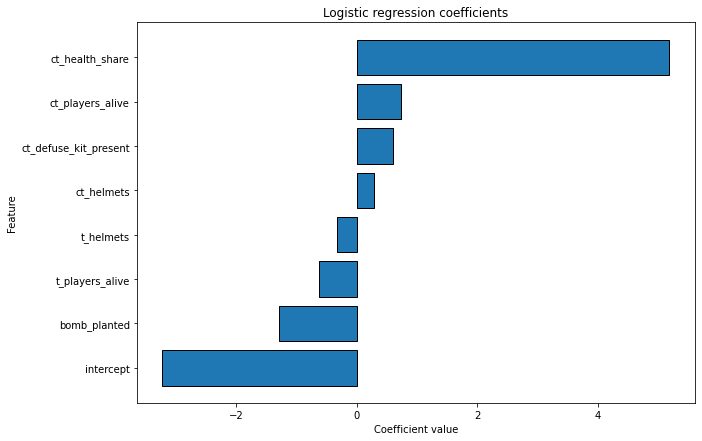

In [117]:
plt.figure(figsize=(10, 7))
plt.barh(coef_frame['feature'], coef_frame['coefficient'], edgecolor='black')
plt.xlabel('Coefficient value')
plt.ylabel('Feature')
plt.title("Logistic regression coefficients")
plt.show()

As we can see, all the coefficient values have the same logic as in the EDA phase. This proves that the feature engineering we have done and the model fitting phase was correct. 

## Xgboost model

Xgboost stands for extreme gradient boosting. It is not as interpratable as logistic regression but is much more flexible and in practise has proven time and time again that it gives better results than logistic regression. 

### Hyperparameter tuning for xgboost

In [118]:
# Defining a list of hyperparameters 
hp_dict = {
    'n_estimators': [60, 90, 120], 
    'max_depth': [4, 6, 8], 
    'eval_metric': ['logloss'],
    'use_label_encoder': [False]
}

# Creating the hp grid 
hp_grid = ParameterGrid(hp_dict)

In [119]:
# Placeholders for the iteration
auc_val_best = 0 
best_hp = {}
results = pd.DataFrame({})

# Iterating through all the parameters and evaluating the results 
for i, hp in enumerate(hp_grid): 
    # Initiating the empty model/classifier 
    clf = xgb.XGBClassifier(**hp)

    # Fitting on data 
    clf.fit(train_X, train_Y)

    # Predicting on the validation set 
    yhat_val = [x[1] for x in clf.predict_proba(val_X)]

    # Calculating the AUC metric 
    auc_val = roc_auc_score(val_Y, yhat_val)

    # Adding to the results frame 
    hp_results = pd.DataFrame(hp, index=[i])
    hp_results['auc'] = auc_val
    results = results.append(hp_results)

    # Checking if this is the highest auc 
    if auc_val > auc_val_best:
        auc_val_best = auc_val 
        best_hp = hp 

# Sorting by the AUC score 
results.sort_values('auc', ascending=False, inplace=True)

In [120]:
# Printing out the results frame 
print(results)

  eval_metric  max_depth  n_estimators  use_label_encoder       auc
8     logloss          8           120              False  0.845637
7     logloss          8            90              False  0.845031
6     logloss          8            60              False  0.844215
4     logloss          6            90              False  0.843509
5     logloss          6           120              False  0.843014
3     logloss          6            60              False  0.842822
2     logloss          4           120              False  0.841861
1     logloss          4            90              False  0.841591
0     logloss          4            60              False  0.840987


In [121]:
# Printing out the best hyper parameter dictionary
print(f"Best hp: {best_hp}")

Best hp: {'eval_metric': 'logloss', 'max_depth': 8, 'n_estimators': 120, 'use_label_encoder': False}


### XGB auc statistic on each of the data sets

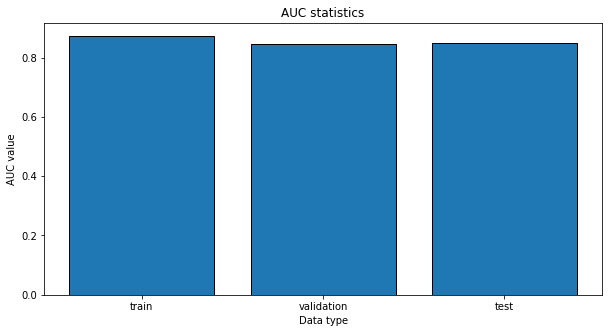

In [123]:
clf_xgb = xgb.XGBClassifier(**best_hp)
clf_xgb.fit(train_X, train_Y)

# Getting the AUC statistics for train, validation and test sets 
yhat_train = [x[1] for x in clf_xgb.predict_proba(train_X)]
yhat_val = [x[1] for x in clf_xgb.predict_proba(val_X)]
yhat_test = [x[1] for x in clf_xgb.predict_proba(test_X)]

train_auc = round(roc_auc_score(train_Y, yhat_train), 4)
val_auc = round(roc_auc_score(val_Y, yhat_val), 4)
test_auc = round(roc_auc_score(test_Y, yhat_test), 4)

# Creating a dataframe for ploting 
auc_xgb_results = pd.DataFrame({
    'auc_xgb': [train_auc, val_auc, test_auc]
}, index=['train', 'validation', 'test'])

# Ploting the results 
plt.figure(figsize=(10, 5))
plt.bar(
    auc_xgb_results.index, 
    auc_xgb_results['auc_xgb'],
    edgecolor='black'
)
plt.title("AUC statistics")
plt.ylabel("AUC value")
plt.xlabel("Data type")
plt.show()

In [124]:
print(auc_xgb_results)

            auc_xgb
train        0.8727
validation   0.8456
test         0.8474


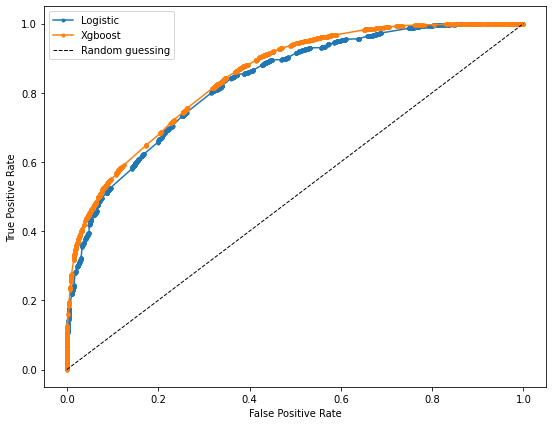

In [39]:
# Calculating the false positive rate and true positive rate for all the tresholds
fpr_xgb, tpr_xgb, _ = roc_curve(test_Y, yhat_test)

# Plot the roc curve for the model
plt.figure(figsize=(9, 7))
plt.plot(fpr_logistic, tpr_logistic, marker='.', label='Logistic')
plt.plot(fpr_xgb, tpr_xgb, marker='.', label='Xgboost')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 1, linestyle='--', label='Random guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

All the metrics, both in the validation set and test set, are better for xgboost. Thus, we will save the model and use it for later. 

In [40]:

# Creating a directory to save the model objects 
_dir_name = os.path.join("..", "ml_models")
if not os.path.exists(_dir_name):
    os.mkdir(_dir_name)

_model_path_xgb = os.path.join(_dir_name, "ml-model-xgb.pkl")
_model_path_lr = os.path.join(_dir_name, "ml-model-lr.pkl")

# Saving the model 
pickle.dump(clf_xgb, open(_model_path_xgb, "wb"))
pickle.dump(clf_lr, open(_model_path_lr, "wb"))

# Saving the features for future use 
_feature_path = os.path.join(_dir_name, "ml-features.json")
with open(_feature_path, 'w') as f:
    json.dump(train_X.dtypes.astype(str).to_dict(), f)

# Job well done. Right? 

So we have done our analysis, did a bunch of feature engineering, compared the baseline model to a more powerful one and saved the best model to a file. Alot of data scientists would pat themselves on the back and call it a day. But a true data engineer would ask the following questions:

* How will anybody reproduce these results in the future?
* How can my colleagues use this model? 
* How can the business clients use this model? 
* How to add new features to the model, if everyone is already using it? 
* How to know, how many times and what kind of inputs were given to the created model? 

And much more. 